<style type="text/css">

.responsive {
 width: 100%;
 height: 25%;
}

.list-group-item.active, .list-group-item.active:focus, .list-group-item.active:hover {
    z-index: 2;
    color: #fff;
    background-color: #1B175E;
    border-color: #337ab7;
}
h1, h2, h3, h4 {
    color: #000002;
    background-color: #1B175E;
    background-image:
      linear-gradient(to right,
       #fff, #ffff00
     );

}

h1, h2, h3, h4, p {
    color: #000002;
}

a {
    color: #1B175E;
}
</style>


In [1]:
rm(list = ls())


In [2]:
install.packages('keras')
library(keras)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Modelo Redes Neuronales

Vamos a crear una red neuronal que solo tenga una hidden layer. Vamos a usar la siguiente regla del pulgar para escoger el número de neuronas:
$$N_h=\frac{N_s}{\alpha\cdot(N_i+N_o)}$$
En donde:
- $N_i:$ Es el número de las neuronas inputs (número de columnas).
- $N_o:$ Número de neuronas en la capa de salida (número de categorías posibles).
- $N_s:$ Número de observaciones.
- $\alpha:$ Factor arbitrario entre 2 y 10.


In [5]:
load("datos_para_modelar.RData")
load("datos_para_testear.RData")

In [6]:
train <- data_train
test <- data_test

In [7]:
table(train$name)


Lopez Petro Uribe 
 3419  2838  2940 

In [8]:
train$cat <- ifelse(train$name == "Lopez", 1, ifelse(train$name == "Uribe",2,3))

In [ ]:
train

In [ ]:
Y <- train$cat
Y

In [11]:
Y <- to_categorical(Y)

In [ ]:
Y

In [13]:
dim(Y)

[1] 9197    4

In [14]:
class(Y)

[1] "matrix" "array"

In [16]:
X <- as.matrix(data_train[,4:103])
class(X)

[1] "matrix" "array"

In [17]:
dim(X)

[1] 9197  100

In [18]:
set.seed(1234)

In [19]:
n <- nrow(train)
data_rows <- floor(0.80 * n)
train_indices <- sample(1:n, data_rows)
X_train <- X[train_indices, ]
X_test <- X[-train_indices, ]
y_train <- Y[train_indices, ]
y_test <- Y[-train_indices, ]

In [23]:
n_h = nrow(X_train)/(2*(ncol(X_train) + 3))
n_h

[1] 23.80906

## Modelo con una capa

In [24]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 50, activation = 'relu', input_shape = ncol(X_train)) %>% 
  layer_dense(units = 4, activation = 'softmax')
summary(model)

model %>% compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = c('CategoricalAccuracy')
)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1 (Dense)                    (None, 50)                      5050        
 dense (Dense)                      (None, 4)                       204         
Total params: 5,254
Trainable params: 5,254
Non-trainable params: 0
________________________________________________________________________________


In [25]:
history <- model %>% 
  fit(
    X_train, y_train, 
    epochs = 30, 
    # Truco pa la vida. El batch_size debe ser un número del estilo 2^x por motivos
    # de eficiencia computacional
    batch_size = 2^4,
    # Toca set pequeño de validación porque estamos jodidos de datos
    validation_split = 0.2
  )


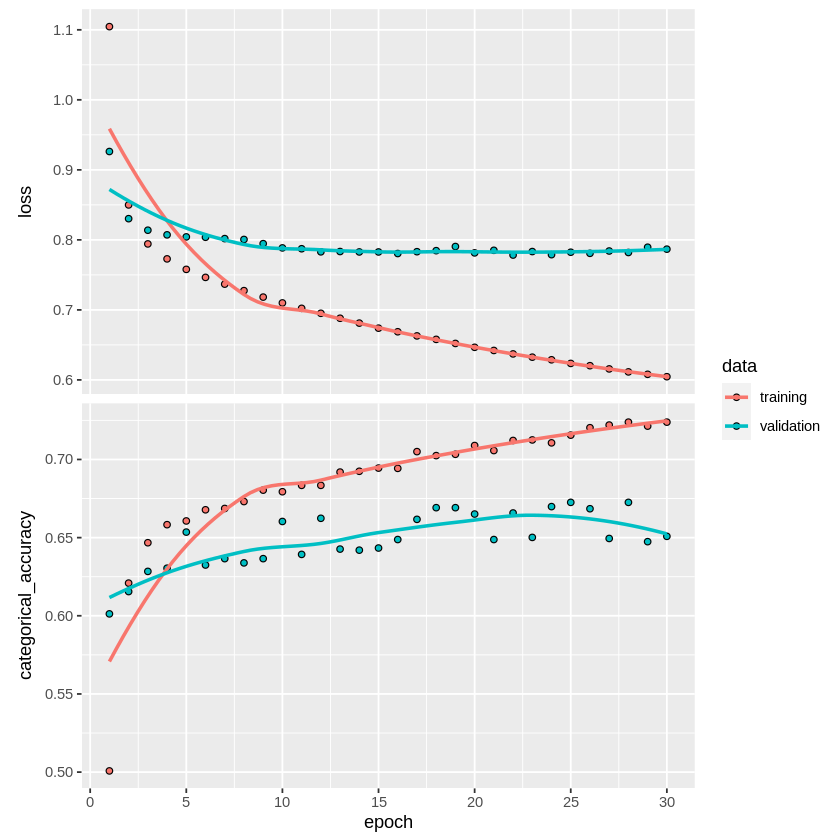

In [27]:
plot(history)

¿Que significa que la muestra de validación sea más alta que la de entrenamiento?

In [28]:
model %>% evaluate(X_test, y_test)

loss categorical_accuracy 
           1.4007212            0.2076087

##Modelo con dos capas

In [32]:
model2 <- keras_model_sequential() 
model2 %>% 
  layer_dense(units = 50, activation = 'relu', input_shape = ncol(X_train)) %>% 
  layer_dense(units = 25, activation = 'relu') %>% 
  layer_dense(units = 4, activation = 'softmax')
summary(model2)

model2 %>% compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = c('CategoricalAccuracy')
)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_4 (Dense)                    (None, 50)                      5050        
 dense_3 (Dense)                    (None, 25)                      1275        
 dense_2 (Dense)                    (None, 4)                       104         
Total params: 6,429
Trainable params: 6,429
Non-trainable params: 0
________________________________________________________________________________


In [33]:
history <- model2 %>% 
  fit(
    X_train, y_train, 
    epochs = 30, 
    # Truco pa la vida. El batch_size debe ser un número del estilo 2^x por motivos
    # de eficiencia computacional
    batch_size = 2^4,
    # Toca set pequeño de validación porque estamos jodidos de datos
    validation_split = 0.2
  )


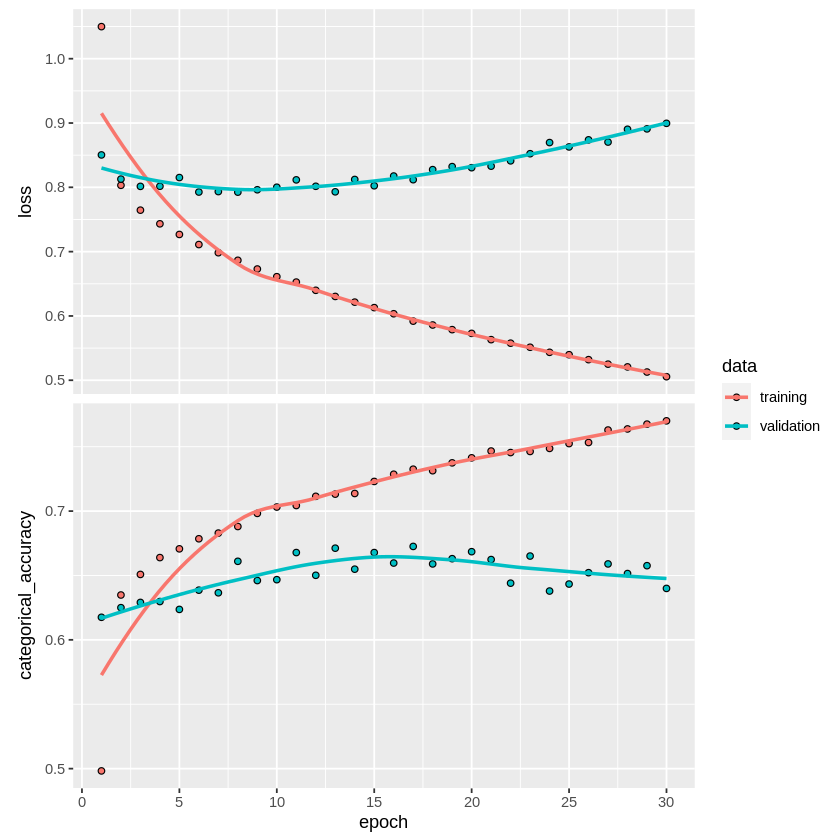

In [34]:
plot(history)

In [35]:
model2 %>% evaluate(X_test, y_test)

loss categorical_accuracy 
           0.8877497            0.6581522

##Predicción

In [ ]:
Test <- as.matrix(data_test[,3:102])

In [ ]:
y_hat <- model  %>% predict(Test) 

In [ ]:
y_hat <- as.data.frame(y_hat)
colnames(y_hat)[which(names(y_hat) == "V2")] <- "Lopez"
colnames(y_hat)[which(names(y_hat) == "V3")] <- "Uribe"
colnames(y_hat)[which(names(y_hat) == "V4")] <- "Petro"
y_hat <- y_hat[-1]

In [ ]:
y_hat <- y_hat %>% mutate(name=names(.)[max.col(.)]) #Saca el la columna con el máximo valor predicho

In [ ]:
name <- as.matrix(y_hat$name)

In [ ]:
id <- as.matrix(test$id)


In [ ]:
predict <- data.frame(
  id = id,
  name = name 
)

In [ ]:
write.csv(predict, "predict.csv", row.names = FALSE)